# 1. Setup

In [1]:
import sys
sys.path.append('../..')
from mobiquity.names import *

from shutil import rmtree

# 2. Prepare data

## 2.1. Zones

In [2]:
zones = U.load(DATA / 'zones/in_2020.parquet',
               columns='geoid scale county urba geometry'.split(),
               filters=[('aland', '>', 0)]).disp()

7,072 rows x 5 cols; Memory: 1.0 MiB; <Projected CRS: EPSG:3857>


,geoid,scale,county,urba,geometry
,<object>,<category>,<category>,<category>,<geometry>
0,18001,County,Adams,"Decatur, IN","POLYGON ((-9469884.850438 4961839.1876, -94698..."


## 2.2. SES

In [3]:
ses_cols = D(geoid='geoid', popu='d_popu', pop_density='d_popdens',
             adi_nat='s_adi', svi='s_svi', sedi='s_sedi',
             p_poc='s_poc', p_pov='s_poverty', p_noinsur='s_noinsur',
             p_disabled='s_disable', p_noveh='s_carless')

In [4]:
ses = (U.load(DATA / 'ses/ses.parquet')
       .pipe(lambda df: df[df.geoid.str[:2] == '18'])
       .set_index('geoid').rename(columns=ses_cols).reset_index()
       .assign(s_altmode=lambda df: df['p_transit'] + df['p_walkbike'])
       [list(ses_cols.values())]).disp()

7,144 rows x 11 cols; Memory: 0.7 MiB


,geoid,d_popu,d_popdens,s_adi,s_svi,s_sedi,s_poc,s_poverty,s_noinsur,s_disable,s_carless
,<object>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>
0,18001,35685.0,105.288811,0.716667,0.598,0.561776,0.047527,0.153265,0.195334,0.26639,0.127453


## 2.3. Health

In [5]:
health_cols = D(geoid='geoid', health='h_health', asthma='h_asthma',
                cancer='h_cancer', copd='h_copd', disabl='h_disable',
                risk='h_riskbeh', insur='h_insurnc', prevent='h_prevent')

In [6]:
health = (U.load(DATA / 'equity_atlas/health/health.parquet',
                 columns=list(health_cols)).set_index('geoid')
          .rename(columns=health_cols).reset_index()).disp()

7,080 rows x 9 cols; Memory: 0.9 MiB


,geoid,h_health,h_asthma,h_cancer,h_copd,h_disable,h_riskbeh,h_insurnc,h_prevent
,<object>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>
0,18001,0.217929,0.110429,0.072714,0.097714,0.326857,0.282476,0.103143,0.644625


## 2.4. EJ

In [7]:
ejs_cols = D(geoid='geoid', demidx='s_demidx', pm25='e_pm25',
             ozone='e_ozone', dslpm='e_dieslpm', cancer='e_cancer',
             resp='e_resptox', ptraf='e_traffic')

In [8]:
ejs = (U.load(DATA / 'equity_atlas/ejs.parquet',
              columns=list(ejs_cols)).set_index('geoid')
       .rename(columns=ejs_cols).reset_index()).disp()

7,078 rows x 8 cols; Memory: 0.7 MiB


,geoid,s_demidx,e_pm25,e_ozone,e_dieslpm,e_cancer,e_resptox,e_traffic
,<object>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>
0,18001,0.214688,0.5,0.48913,0.5,0.478261,0.413043,0.51087


## 2.5. Accessibility

In [9]:
xs = pd.read_parquet(
    DATA / 'access/access/indiana.parquet',
    filters=[('measure', '==', 'Gravity'), ('thresh', '==', '45')],
    columns='kind mode scale geoid access'.split())
xs = xs.astype(D(geoid=str, scale=str))
scales = xs.groupby(['scale', 'geoid']).size().reset_index(0)['scale']
res = [scales]
for mode, df in xs.groupby('mode'):
    res.append(df.groupby('geoid')['access'].sum().rename(mode.lower()))
kinds = D(lowwage='Low wage', poc='POC', lowedu='Low edu',
            pois='Total', grocry='Groceries', medical='Medical',
            edu='Education', support='Social Support')
for label, kind in kinds.items():
    df = xs.query(f'kind=="{kind}"')
    res.append(df.groupby('geoid')['access'].sum().rename(label))
xs = pd.concat(res, axis=1).fillna(0)#.astype(np.float32)
xs['xsgap'] = (xs.drive - xs.transit) / (xs.drive + xs.transit)
for col in xs.columns[1:-1]:
    for _, df in xs.groupby('scale'):
        xs.loc[df.index, col] = 1 - U.normalize(df[col])
xs = xs.drop(columns='scale').sort_index().fillna(0)
xs = xs.rename(columns=lambda x: 'x_' + x).reset_index().disp()

7,070 rows x 14 cols; Memory: 0.8 MiB


,geoid,x_bike,x_drive,x_transit,x_walk,x_lowwage,x_poc,x_lowedu,x_pois,x_grocry,x_medical,x_edu,x_support,x_xsgap
,<object>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>
0,18001,1.0,0.931045,0.0,0.0,0.918118,0.961171,0.921484,0.951769,0.950163,0.951422,0.901998,0.945801,1.0


## 2.6. Combine and export

In [10]:
dash = ses.merge(ejs).merge(health).merge(xs).set_index('geoid').fillna(0)
dash = dash[~dash.index.duplicated()]
dash['scale'] = dash.index.str.len()
for _, df in dash.groupby('scale'):
    for col in ['d_popu', 'd_popdens']:
        dash.loc[df.index, col] = U.normalize(df[col])
dash = dash.drop(columns='scale').disp()

7,048 rows x 38 cols; Memory: 2.0 MiB


,d_popu,d_popdens,s_adi,s_svi,s_sedi,s_poc,s_poverty,s_noinsur,s_disable,s_carless,...,x_walk,x_lowwage,x_poc,x_lowedu,x_pois,x_grocry,x_medical,x_edu,x_support,x_xsgap
geoid,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,...,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>
18001,0.030878,0.03463,0.716667,0.598,0.561776,0.047527,0.153265,0.195334,0.26639,0.127453,...,0.0,0.918118,0.961171,0.921484,0.951769,0.950163,0.951422,0.901998,0.945801,1.0


In [11]:
export = zones.assign(_1=1).merge(dash, on='geoid')
export = export.rename(columns={
    x: x.upper() for x in export.columns if x != 'geometry'}).disp()
outpath = DATA / 'equity_atlas/dash'
if outpath.exists(): rmtree(outpath)
export.to_file(outpath, layer='Data')

7,048 rows x 44 cols; Memory: 2.3 MiB; <Projected CRS: EPSG:3857>


,GEOID,SCALE,COUNTY,URBA,geometry,_1,D_POPU,D_POPDENS,S_ADI,S_SVI,...,X_WALK,X_LOWWAGE,X_POC,X_LOWEDU,X_POIS,X_GROCRY,X_MEDICAL,X_EDU,X_SUPPORT,X_XSGAP
,<object>,<category>,<category>,<category>,<geometry>,<int64>,<float32>,<float32>,<float32>,<float32>,...,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>,<float32>
0,18001,County,Adams,"Decatur, IN","POLYGON ((-9469884.850438 4961839.1876, -94698...",1,0.030878,0.03463,0.716667,0.598,...,0.0,0.918118,0.961171,0.921484,0.951769,0.950163,0.951422,0.901998,0.945801,1.0


## 2.7. Modify for Tableau

### 2.7.1. Indicator aliases

### 2.7.2. Indicator selector

In [12]:
print('CASE [Indicator 1]')
for x in ['_1'] + list(dash.columns):
    print("WHEN '{0}' THEN [{0}]".format(x.upper()))
print('END')

CASE [Indicator 1]
WHEN '_1' THEN [_1]
WHEN 'D_POPU' THEN [D_POPU]
WHEN 'D_POPDENS' THEN [D_POPDENS]
WHEN 'S_ADI' THEN [S_ADI]
WHEN 'S_SVI' THEN [S_SVI]
WHEN 'S_SEDI' THEN [S_SEDI]
WHEN 'S_POC' THEN [S_POC]
WHEN 'S_POVERTY' THEN [S_POVERTY]
WHEN 'S_NOINSUR' THEN [S_NOINSUR]
WHEN 'S_DISABLE' THEN [S_DISABLE]
WHEN 'S_CARLESS' THEN [S_CARLESS]
WHEN 'S_DEMIDX' THEN [S_DEMIDX]
WHEN 'E_PM25' THEN [E_PM25]
WHEN 'E_OZONE' THEN [E_OZONE]
WHEN 'E_DIESLPM' THEN [E_DIESLPM]
WHEN 'E_CANCER' THEN [E_CANCER]
WHEN 'E_RESPTOX' THEN [E_RESPTOX]
WHEN 'E_TRAFFIC' THEN [E_TRAFFIC]
WHEN 'H_HEALTH' THEN [H_HEALTH]
WHEN 'H_ASTHMA' THEN [H_ASTHMA]
WHEN 'H_CANCER' THEN [H_CANCER]
WHEN 'H_COPD' THEN [H_COPD]
WHEN 'H_DISABLE' THEN [H_DISABLE]
WHEN 'H_RISKBEH' THEN [H_RISKBEH]
WHEN 'H_INSURNC' THEN [H_INSURNC]
WHEN 'H_PREVENT' THEN [H_PREVENT]
WHEN 'X_BIKE' THEN [X_BIKE]
WHEN 'X_DRIVE' THEN [X_DRIVE]
WHEN 'X_TRANSIT' THEN [X_TRANSIT]
WHEN 'X_WALK' THEN [X_WALK]
WHEN 'X_LOWWAGE' THEN [X_LOWWAGE]
WHEN 'X_POC' THEN [

# 3. Analyze

## 3.1. Correlation

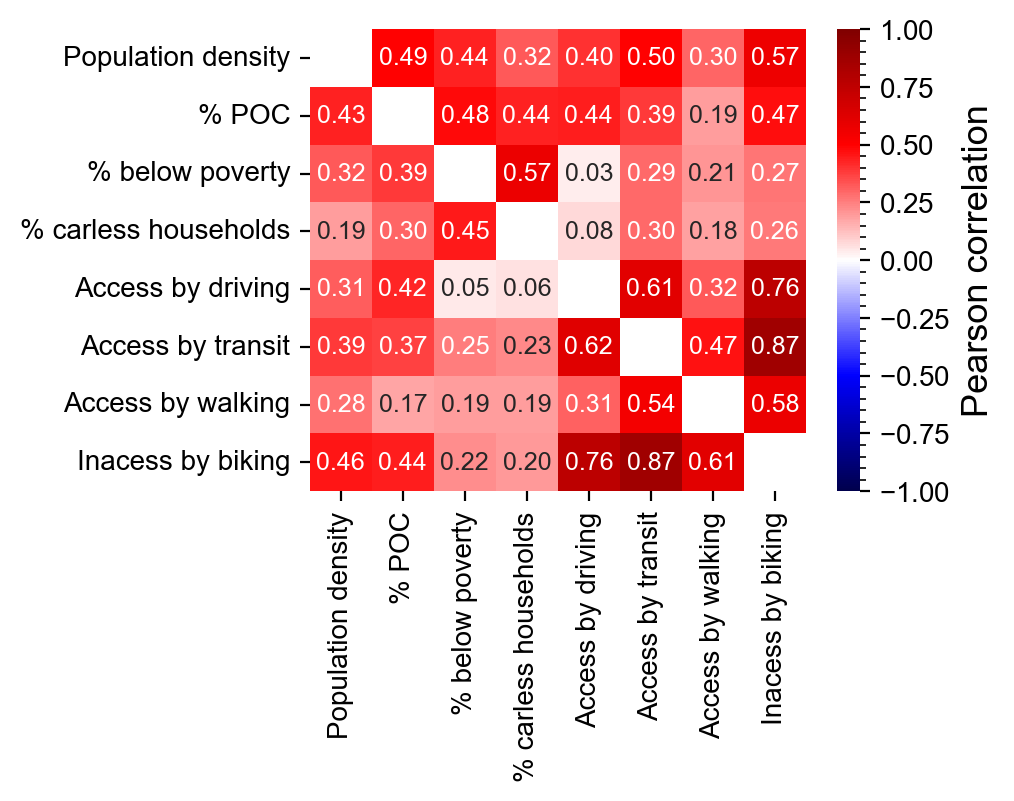

In [13]:
cols = D(
    # d_popu='Population',
    d_popdens='Population density',
    s_poc='% POC',
    s_poverty='% below poverty',
    s_carless='% carless households',
    x_drive='Access by driving',
    x_transit='Access by transit',
    x_walk='Access by walking',
    x_bike='Inacess by biking',
)
df = zones[['geoid', 'scale', 'urba']].merge(ses).merge(xs)
# df = df.query('urba=="Indianapolis, IN"')
# df = df.query('urba=="Chicago, IL--IN"')
df = df[df['scale'] != 'County'].set_index('scale')[list(cols)]
for col in df.columns:
    if col[0] == 'x': df[col] = 1 - df[col]
df = df.rename(columns=cols)
tr = np.triu(df.loc['Tract'].corr(), 1)
bg = np.tril(df.loc['BG'].corr(), -1)
corr = tr + bg
np.fill_diagonal(corr, np.nan)
corr = Pdf(corr, columns=df.columns, index=df.columns)
ax = U.plot(size=(4, 3), xminor=0, yminor=0, dpi=200, gridcolor='none')
sns.heatmap(corr, ax=ax, cmap='seismic', vmin=-1, vmax=1,
            annot=True, fmt='.2f', annot_kws=D(fontsize=9),
            cbar_kws=D(label='Pearson correlation'));

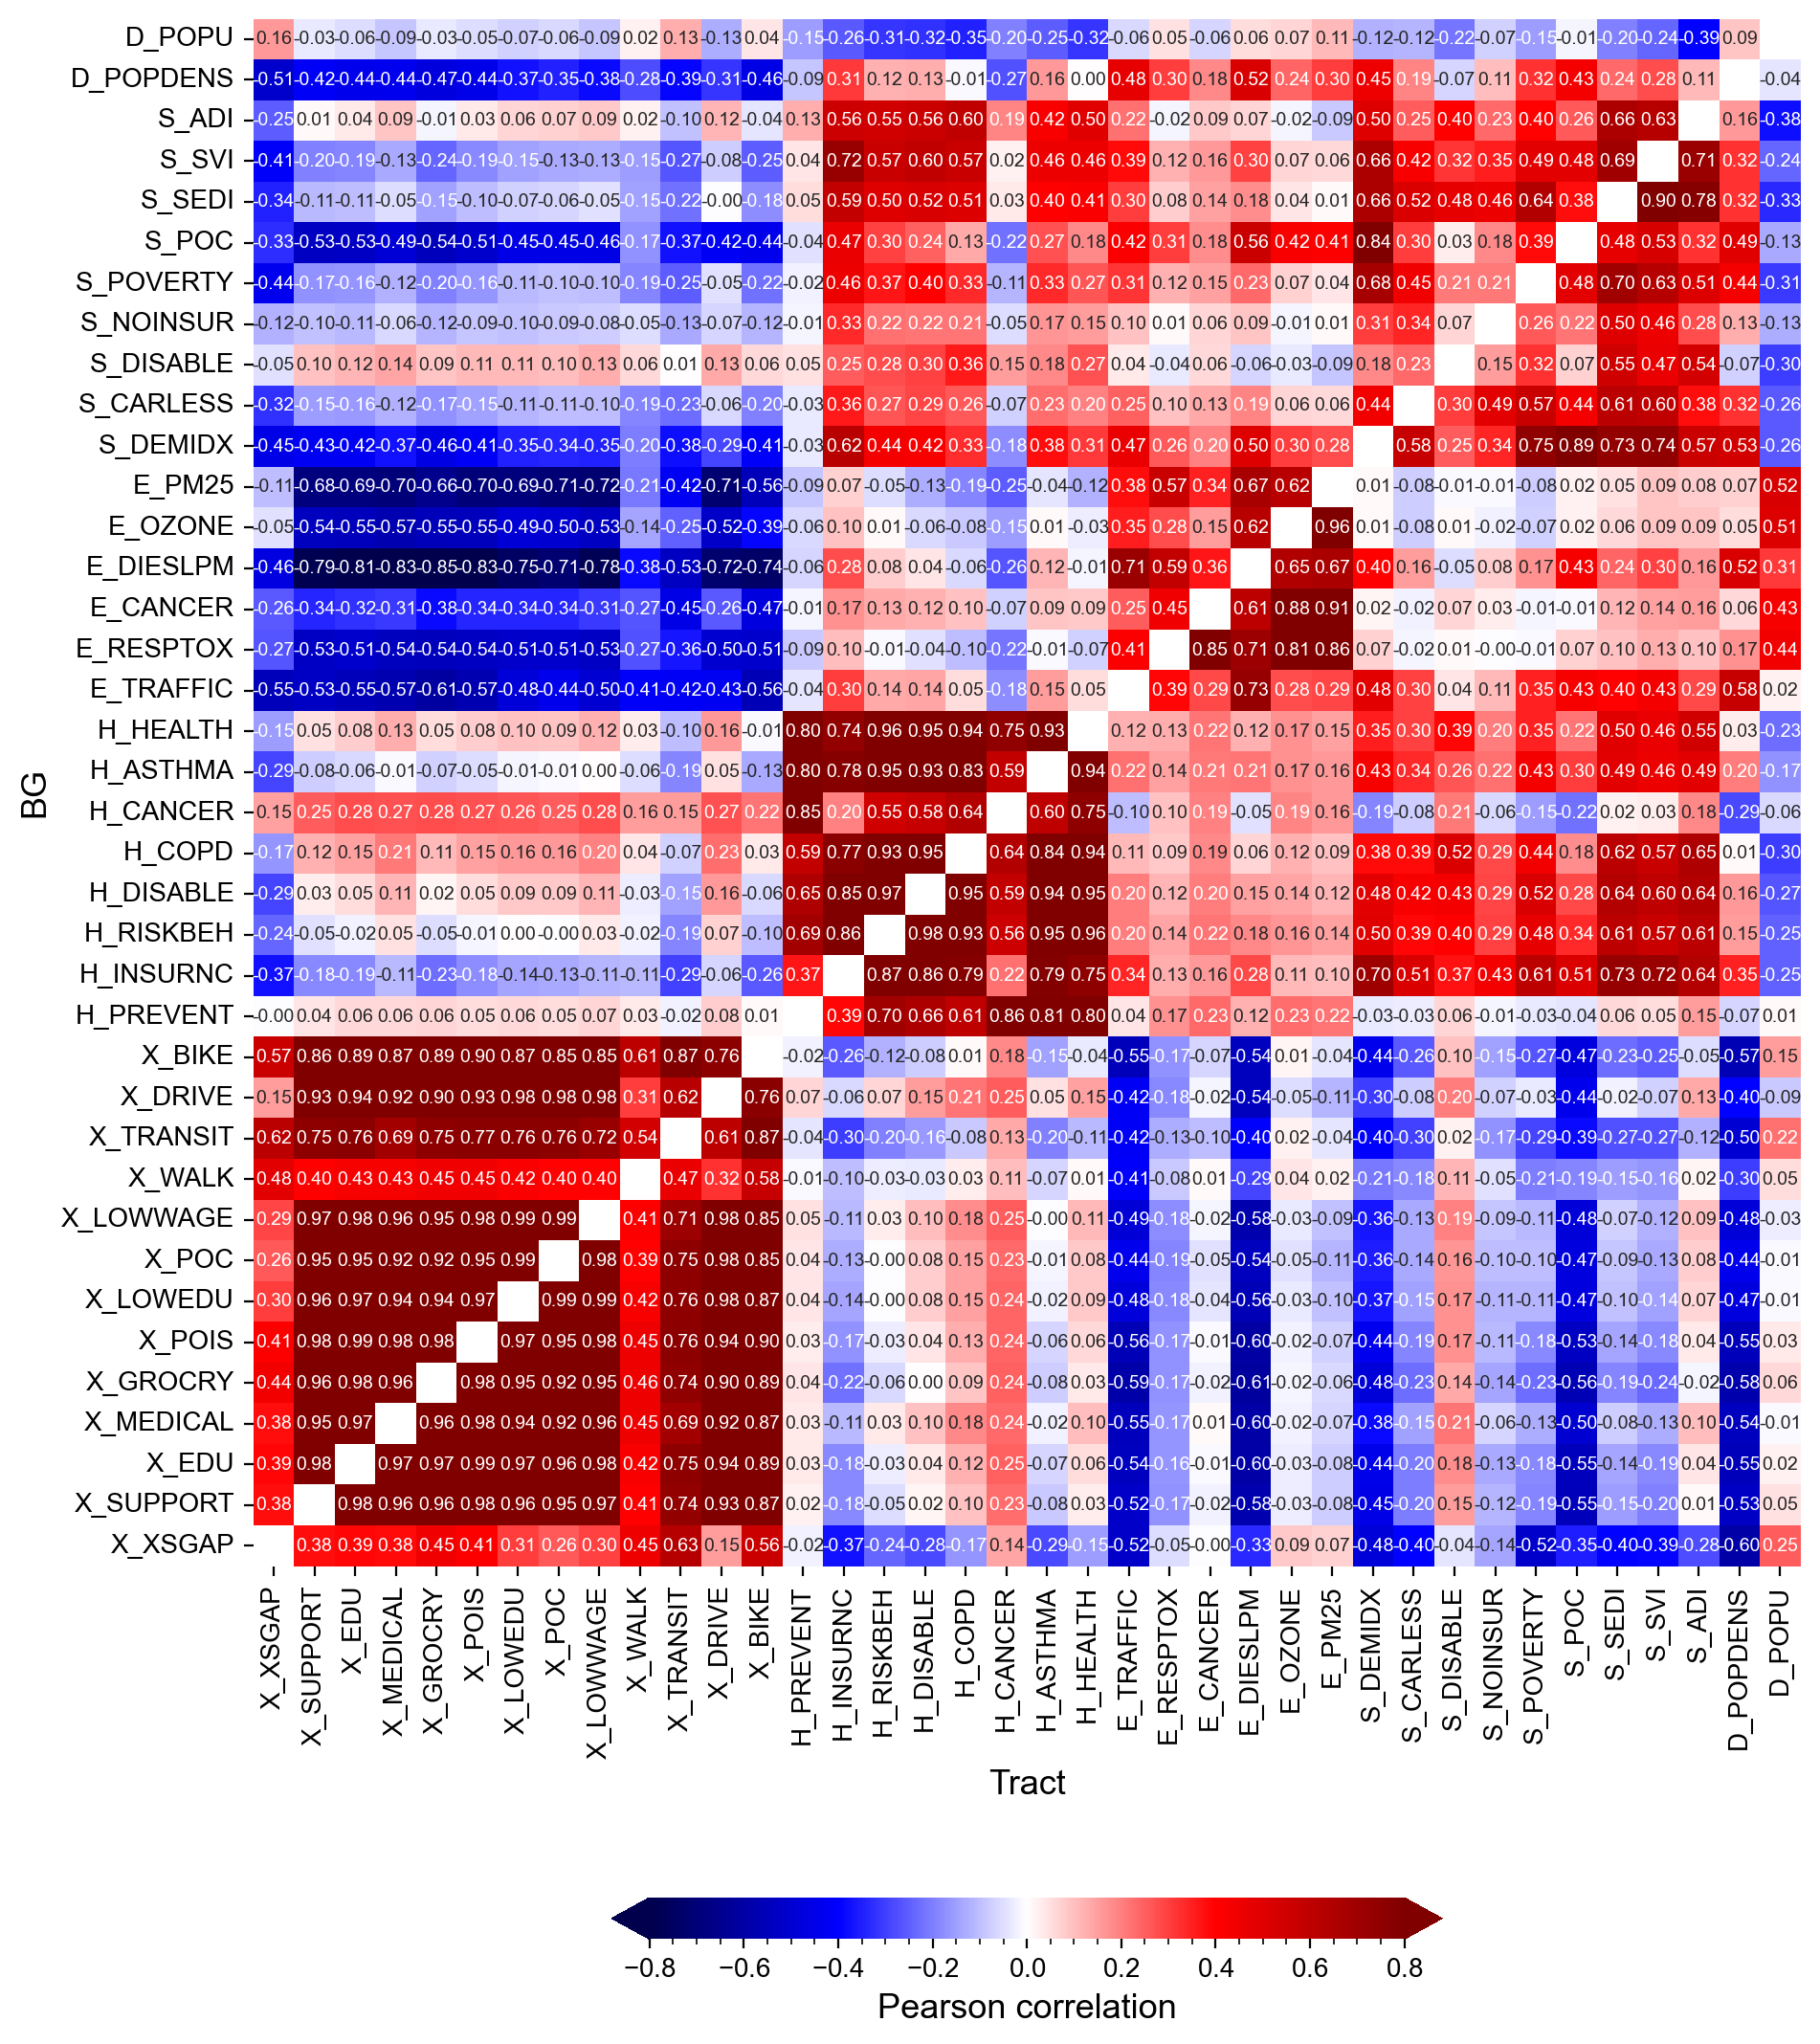

In [14]:
def plot_corr_matrix(dash=dash, rank=False, size=(14, 15), dpi=200):
    df = dash.assign(scale=dash.index.str.len()
                     .map({12: 'BG', 11: 'Tract'}))
    df = df.dropna(subset='scale').set_index('scale')
    df = df.rename(columns=str.upper)
    if rank:
        for col in df.columns: df[col] = df[col].rank(pct=True)
    corr = (np.triu(df.loc['BG', :].corr(), 1) +
            np.tril(df.loc['Tract', :].corr(), -1))
    corr = Pdf(corr, index=df.columns, columns=df.columns)
    np.fill_diagonal(corr.values, np.nan)
    ax = U.plot(size=size, dpi=dpi)
    sns.heatmap(corr, square=True, ax=ax,
                cmap='seismic', vmax=.8, vmin=-.8,
                annot=True, fmt='.2f', annot_kws=D(fontsize=7),
                cbar_kws=D(shrink=0.4, orientation='horizontal',
                           label='Pearson correlation', extend='both'))
    ax.invert_xaxis(); ax.grid(alpha=0); ax.minorticks_off()
    ax = U.plot(ax, xlab='Tract', ylab='BG')

plot_corr_matrix() # 3s